In [1]:
# Import libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

pd.set_option("display.max_colwidth", None)

In [2]:
# Set the location to read the files
base_path = "C:\\Users\\User\\Documents\\My_Python_Repos\\NLP_Projects\\Product_Feedback\\"
training_path = base_path + "training"
test_path = base_path + "test"

In [3]:
# Import the training data from the JSON files
train_x = []
train_y = []
categories = []
for item in os.listdir(training_path):
    category = item.strip('train_').split('.')[0]
    categories.append(category)
    with open(training_path+'\\'+item, 'r') as file:
        for line in file:
            read_text = json.loads(line)['reviewText']
            train_x.append(read_text)
            train_y.append(category)

In [4]:
# Import the test data from the JSON files
test_x = []
test_y_actual = []
for item in os.listdir(test_path):
    category = item.strip('test_').split('.')[0]
    with open(test_path+'\\'+item, 'r') as file:
        for line in file:
            read_text = json.loads(line)['reviewText']
            test_x.append(read_text)
            test_y_actual.append(category)

In [5]:
# Create a dataframe for the training and test data
d = {'Review_Text': train_x, 'Category': train_y}
training_data = pd.DataFrame(data=d)

d = {'Review_Text': test_x, 'Category': test_y_actual}
test_data = pd.DataFrame(data=d)

## Bag of Words

In [6]:
def baw_base (ngram_limit, train_x, test_x):
    # Instantiate the vectoriser
    vectorizer = CountVectorizer(ngram_range=(1, ngram_limit))
    
    # Call fit transform on the training data and assign as vectors 
    train_x_vectors = vectorizer.fit_transform(train_x)

    # Instantiate an svm with a linear kernel. 
    clf_svm = svm.SVC(kernel='linear')

    # Fit the model to the train x vectors and the y labels
    clf_svm.fit(train_x_vectors, train_y)

    # Predict on the test data
    test_x_pred = vectorizer.transform(test_x)

    # Predict on the test data
    predicted = clf_svm.predict(test_x_pred)

    return predicted

In [7]:
# Create an empty list to store the accuracy and the ngram range
accuracy_list = []
ngram_list = []

# Try implement for ngrams up to 3 to see which performs better. Iterate 1 through 3 for the ngram range

for ngram_limit in range(1,4):

    # Call the function to create the back of words model
    predicted = baw_base(ngram_limit, train_x, test_x)
    
    # Calculate the accuracy score and append to the lists for comparisons
    accuracy = metrics.accuracy_score(test_y_actual, predicted)
    accuracy_list.append(accuracy)
    ngram_list.append(ngram_limit)
accuracy_df = pd.DataFrame({'Accuracy': accuracy_list, 'ngram_limit': ngram_list})

Text(0.5, 1.0, 'Accuracy score vs ngram range')

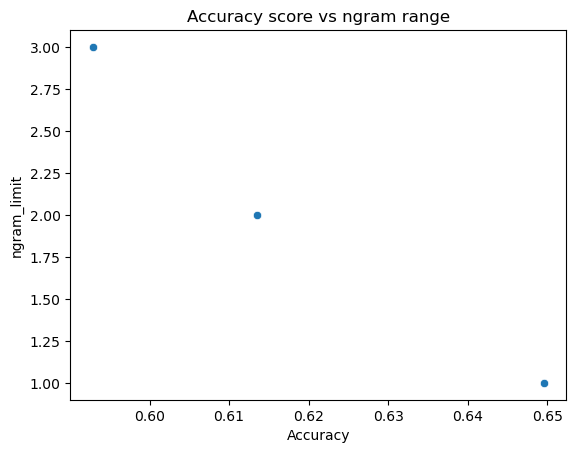

In [8]:
# Plot the accuracy scores
sns.scatterplot(data=accuracy_df, x="Accuracy", y="ngram_limit").set_title("Accuracy score vs ngram range")

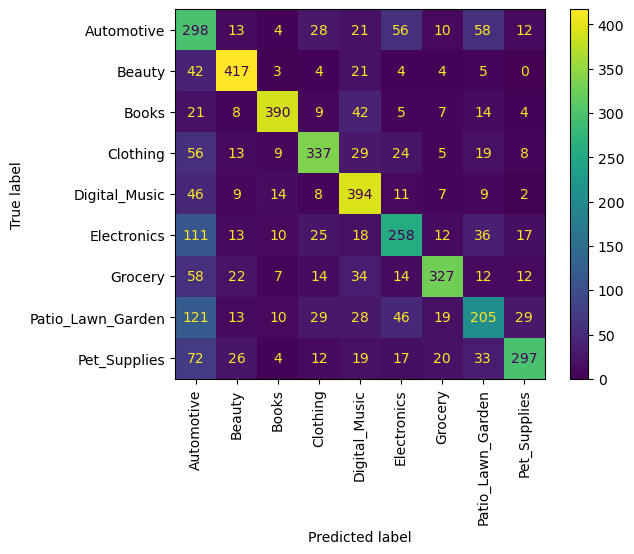

In [9]:
# Confusion Matrix
# Accuracy is highest for the ngram range of 1.

predicted = baw_base(1, train_x, test_x)

confusion_matrix = metrics.confusion_matrix(test_y_actual, predicted, labels = categories)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=categories)

# Plot the confusion matrix
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [10]:
# Classification Report

classification_report = metrics.classification_report(test_y_actual, predicted, labels = categories)
print(classification_report)

                   precision    recall  f1-score   support

       Automotive       0.36      0.60      0.45       500
           Beauty       0.78      0.83      0.81       500
            Books       0.86      0.78      0.82       500
         Clothing       0.72      0.67      0.70       500
    Digital_Music       0.65      0.79      0.71       500
      Electronics       0.59      0.52      0.55       500
          Grocery       0.80      0.65      0.72       500
Patio_Lawn_Garden       0.52      0.41      0.46       500
     Pet_Supplies       0.78      0.59      0.67       500

         accuracy                           0.65      4500
        macro avg       0.67      0.65      0.65      4500
     weighted avg       0.67      0.65      0.65      4500



## Stemmer and Lemmatisation

In [11]:
# Create a function to stem the phrases from the review text
def my_stemmer(words):
    #instantiate a stemmer
    stemmer = PorterStemmer()

    # Tokenise the phrases into individual words
    words = word_tokenize(words)

    # Loop through the phrases and store the stemmed words in a list
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
        
    #join by spaces to convert the list back into a string
    stemmed_words = " ".join(stemmed_words)
    return stemmed_words

# Create a function to lemmatise
def my_lemma(words):
    # Instantiate a lemmatiser
    lemmatiser = WordNetLemmatizer()
    
    # Tokenise the phrases into individual words
    words = word_tokenize(words)

    #loop through the words in the tokenised list and append the lemmatised word to the lemmatised words lst
    lemmatised_words = []
    for word in words:
        lemmatised_words.append(lemmatiser.lemmatize(word))

    #join by spaces to convert the list back into a string
    lemmatised_words = " ".join(lemmatised_words)
    return lemmatised_words

In [12]:
# Apply the stemmer and lemmatise functions to the training and test data
training_data['stemmed_phrase'] = training_data['Review_Text'].apply(my_stemmer)
training_data['lemma_phrase'] = training_data['Review_Text'].apply(my_lemma)
test_data['stemmed_phrase'] = test_data['Review_Text'].apply(my_stemmer)
test_data['lemma_phrase'] = test_data['Review_Text'].apply(my_lemma)

test_x = test_data['stemmed_phrase']

In [13]:
# Use the bag of words model on the stemmed data
predicted_stemmed = baw_base(1, training_data['stemmed_phrase'], test_data['stemmed_phrase'])
classification_report = metrics.classification_report(test_y_actual, predicted_stemmed, labels = categories)
print(classification_report)

                   precision    recall  f1-score   support

       Automotive       0.38      0.62      0.47       500
           Beauty       0.78      0.84      0.81       500
            Books       0.87      0.78      0.82       500
         Clothing       0.75      0.72      0.74       500
    Digital_Music       0.65      0.81      0.72       500
      Electronics       0.63      0.54      0.58       500
          Grocery       0.82      0.64      0.72       500
Patio_Lawn_Garden       0.54      0.43      0.48       500
     Pet_Supplies       0.81      0.61      0.70       500

         accuracy                           0.67      4500
        macro avg       0.69      0.67      0.67      4500
     weighted avg       0.69      0.67      0.67      4500



In [14]:
# Use the bag of words model on the lemmatized data
predicted_lemma = baw_base(1, training_data['lemma_phrase'], test_data['lemma_phrase'])
classification_report = metrics.classification_report(test_y_actual, predicted_lemma, labels = categories)
print(classification_report)

                   precision    recall  f1-score   support

       Automotive       0.37      0.61      0.46       500
           Beauty       0.79      0.84      0.81       500
            Books       0.86      0.78      0.82       500
         Clothing       0.76      0.70      0.73       500
    Digital_Music       0.65      0.79      0.71       500
      Electronics       0.61      0.54      0.58       500
          Grocery       0.80      0.65      0.72       500
Patio_Lawn_Garden       0.55      0.43      0.48       500
     Pet_Supplies       0.80      0.60      0.69       500

         accuracy                           0.66      4500
        macro avg       0.69      0.66      0.67      4500
     weighted avg       0.69      0.66      0.67      4500



## Word Vectors

In [15]:
import spacy

nlp = spacy.load("en_core_web_md")

C:\Users\User\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Create word vector representations for each text in the training data
docs = [nlp(text) for text in train_x]

# Create a list of all word vectors
train_x_word_vectors = [x.vector for x in docs]

In [17]:
# Build a classifier similar to the bag of words, however, fit the model to the word vectors
clf_svm_wv = svm.SVC(kernel='linear')
clf_svm_wv.fit(train_x_word_vectors, train_y)

SVC(kernel='linear')

In [18]:
# Predict using the new model
# Create word vectors and store this in a list
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors = [x.vector for x in test_docs]
predicted_wv = clf_svm_wv.predict(test_x_word_vectors)

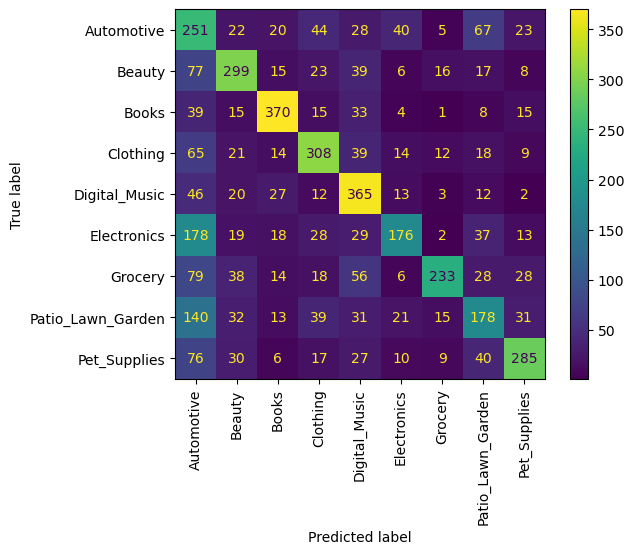

In [19]:
# Confusion Matrix
cm_wv = metrics.confusion_matrix(test_y_actual, predicted_wv, labels = categories)
disp_wv = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_wv, display_labels=categories)

# Plot the confusion matrix
disp_wv.plot()
plt.xticks(rotation=90)
plt.show()

In [20]:
# Classification Report

classification_report_wv = metrics.classification_report(test_y_actual, predicted_wv, labels = categories)
print(classification_report_wv)

                   precision    recall  f1-score   support

       Automotive       0.26      0.50      0.35       500
           Beauty       0.60      0.60      0.60       500
            Books       0.74      0.74      0.74       500
         Clothing       0.61      0.62      0.61       500
    Digital_Music       0.56      0.73      0.64       500
      Electronics       0.61      0.35      0.45       500
          Grocery       0.79      0.47      0.59       500
Patio_Lawn_Garden       0.44      0.36      0.39       500
     Pet_Supplies       0.69      0.57      0.62       500

         accuracy                           0.55      4500
        macro avg       0.59      0.55      0.55      4500
     weighted avg       0.59      0.55      0.55      4500

